In [1]:
import os
os.environ['JAX_PLATFORMS'] = 'cpu'

# This is required to run multiple processes with JAX.
from multiprocessing import set_start_method
set_start_method('spawn', force=True)

In [2]:
from pathlib import Path
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import geodatasets

import config, data, models, train, evaluate

In [3]:
run_dir = Path("/nas/cee-water/cjgleason/ted/swot-ml/runs/Ohio/masked_assimilation/e5_sr_sl_gs_20250819_134746")

fig_dir = run_dir / "figures" 
fig_dir.mkdir(exist_ok=True, parents=True)

In [4]:
import pickle

with open(run_dir / 'test_data.pkl', 'rb') as f:
    results, bulk_metrics, basin_metrics = pickle.load(f)

In [5]:
proj_dir = Path("/nas/cee-water/cjgleason/ted/swot-ml/data/distributed")
metadata_dir = proj_dir / "metadata"
basins = gpd.read_file(metadata_dir / 'Ohio_matchups.geojson').set_index("HYBAS_ID")
basins.index = basins.index.astype(str)

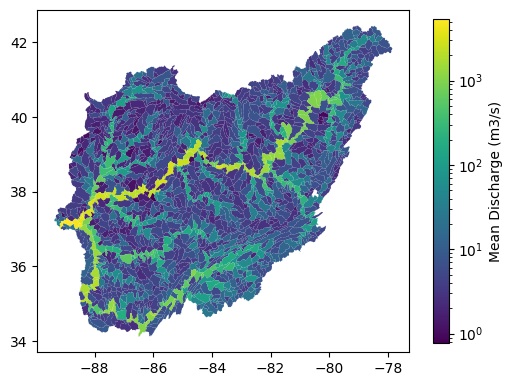

In [6]:
import matplotlib.colors as colors

fig, ax = plt.subplots(figsize=(6, 6))

pred = results['pred']['discharge']

x = pred.groupby('basin').mean()

norm = colors.LogNorm(vmin=x.min(), vmax=x.max())

basins_pred = basins.merge(x, left_index=True, right_index=True)
basins_pred.plot('discharge', ax=ax, norm=norm, cmap='viridis')

sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
plt.colorbar(sm, ax=ax, shrink=0.7, label='Mean Discharge (m3/s)')

fig.savefig(fig_dir/'mean_Q.png', dpi=300)

<Axes: >

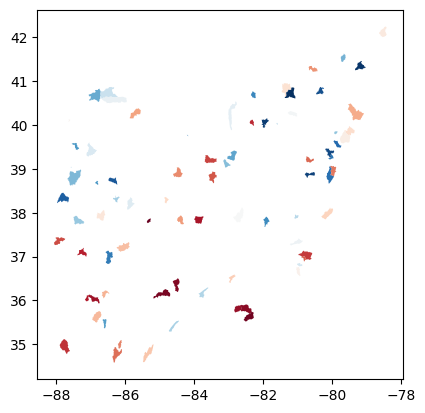

In [18]:
metrics_gdf.plot('NSE', cmap='RdBu')

In [25]:
norm = colors.Normalize(vmin=-1, vmax=1)
norm(-1)

0.0

In [33]:
list(basin_metrics['discharge'])

['num_obs',
 'R2',
 'MAPE',
 'nBias',
 'RE',
 'RB',
 'qRE',
 'qnBias',
 'MAE',
 'RMSE',
 'rRMSE',
 'KGE',
 'NSE',
 'Agreement']

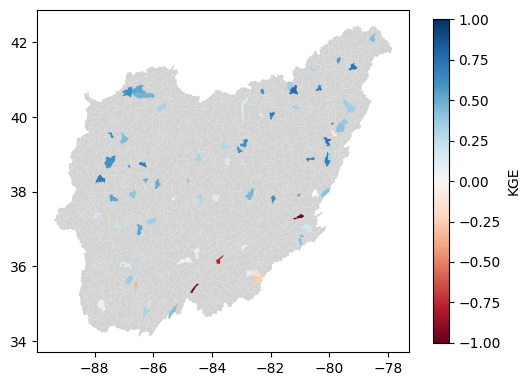

In [35]:
fig, ax = plt.subplots(figsize=(6, 6))

norm = colors.Normalize(vmin=-1, vmax=1)

metrics_gdf = basins.merge(basin_metrics['discharge'], left_index=True, right_index=True)
metrics_gdf['KGE'] = metrics_gdf['KGE'].astype(float)

metrics_gdf.plot(ax=ax, color='lightgrey')
metrics_gdf.plot('KGE', ax=ax, norm=norm, cmap='RdBu')

sm = plt.cm.ScalarMappable(cmap='RdBu', norm=norm)
plt.colorbar(sm, ax=ax, shrink=0.7, label='KGE')

<Axes: xlabel='date'>

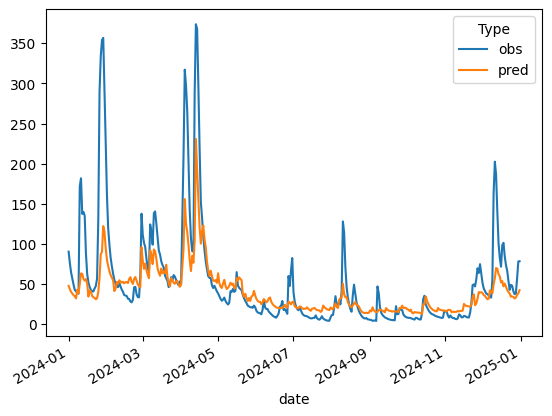

In [54]:
start_date = "2024-01-01"
end_date   = "2024-12-31"

x = results.xs('7090488570', level='basin').sort_index()
x = x.loc[start_date:end_date]

x.columns = x.columns.droplevel(1)
x.plot()

In [55]:
metrics_gdf.sort_values('mean_discharge', ascending=True)['mean_discharge']

HYBAS_ID
7090573280    1.258458
7090582420    1.300843
7090599660    1.537973
7090560430    1.581266
7090565900    1.601753
                ...   
7091090690         NaN
7091091730         NaN
7091092150         NaN
7091092540         NaN
7091093090         NaN
Name: mean_discharge, Length: 1962, dtype: float64

(-5.0, 1.0)

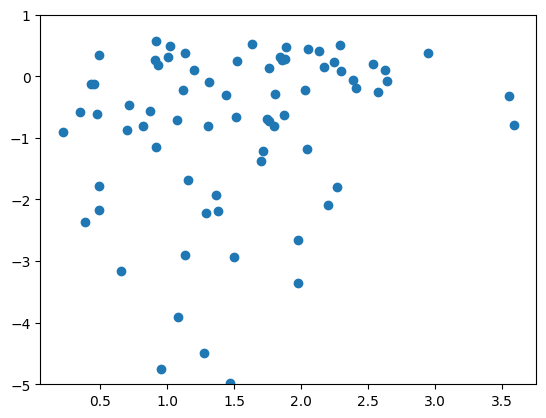

In [46]:
plt.scatter(np.log10(metrics_gdf['mean_discharge']), metrics_gdf['NSE'])
plt.ylim([-5,1])
# plt.xlim([0,1000])

KeyError: Timestamp('2024-04-02 00:00:00')

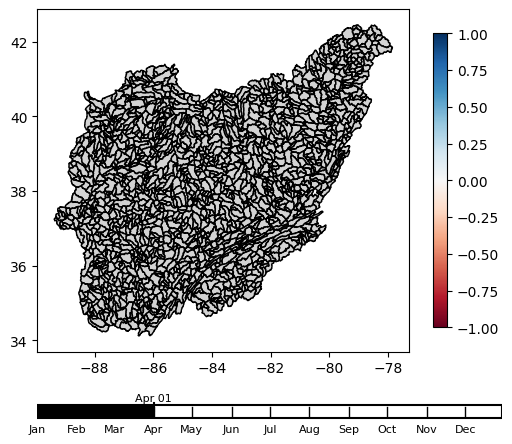

In [7]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
import matplotlib as mpl

# Compute relative change
pred = results['pred']['discharge']
rel_change = pred.groupby('basin').transform(lambda x: np.log10(x / x.median()))

# Date range to animate
dates = pd.date_range('2024-01-01', periods=365)

# Setup figure with two axes: map + progress bar
fig = plt.figure(figsize=(6, 6))
gs = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[10, 1], hspace=0)
ax_map = fig.add_subplot(gs[0])
ax_bar = fig.add_subplot(gs[1])

# Colorbar setup
vmin = -1
vmax = 1
cmap = 'RdBu'
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(sm, ax=ax_map, shrink=0.7)
title = ax_map.set_title("Relative Discharge log10(Q / Q_median)")

# Progress bar drawing function
def draw_progress_bar(ax, frame_date, date_range):
    ax.clear()
    
    # Convert date to number
    current_num = mpl.dates.date2num(frame_date)
    start_num = mpl.dates.date2num(date_range[0])
    end_num = mpl.dates.date2num(date_range[-1])
    
    ax.set_xlim(start_num, end_num)
    ax.set_ylim(0, 1)
    ax.axis('off')

    # Outline rectangle using hollow bar
    ax.barh(
        y=0.5,
        width=end_num - start_num,
        left=start_num,
        height=0.3,
        edgecolor='black',
        facecolor='none',
        linewidth=1.5
    )

    # Fill progress
    ax.barh(0.5, width=current_num - start_num, left=start_num, height=0.3, color='black')

    # Current date marker
    ax.plot([current_num, current_num], [0.5, 0.7], color='black', lw=1.5)
    ax.text(current_num, 0.75, frame_date.strftime('%b %d'), ha='center', fontsize=8)

    # Month ticks
    month_starts = pd.date_range(date_range[0], date_range[-1], freq='MS')
    for m in month_starts:
        mnum = mpl.dates.date2num(m)
        ax.plot([mnum, mnum], [0.4, 0.6], color='black', lw=1)
        ax.text(mnum, 0.2, m.strftime('%b'), ha='center', va='top', fontsize=8)

# Animation update function
def update(frame_date):
    ax_map.clear()
    basins.plot(ax=ax_map, color='lightgrey', edgecolor='black')

    # Join discharge values for current date
    x = rel_change.xs(frame_date, level='date')
    basins_pred = basins.join(x.rename("discharge"))

    # Plot with discharge as color
    basins_pred.plot(
        column='discharge',
        cmap=cmap,
        ax=ax_map,
        legend=False,
        vmin=vmin, vmax=vmax,
    )
    ax_map.set_axis_off()
    title.set_text(f"Relative Discharge on {frame_date.strftime('%Y-%m-%d')}")

    # Update progress bar
    draw_progress_bar(ax_bar, frame_date, dates)

# Run animation
anim = FuncAnimation(fig, update, frames=dates, repeat=False)

# Save using ffmpeg
# May change in future. Use `module spider ffmpeg` load one, and then `which ffmpeg` to find it.
ffmpeg_path = "/modules/spack/packages/linux-ubuntu24.04-x86_64_v3/gcc-13.2.0/ffmpeg-7.0.2-hpqh7mjhtopager73y4223ini6rzot3o/bin/ffmpeg"
mpl.rcParams['animation.ffmpeg_path'] = ffmpeg_path
writer = FFMpegWriter(fps=7, bitrate=6000)
anim.save(fig_dir / "2024.mp4", writer=writer)

In [ ]:
pwd

In [ ]:
with open(fig_dir / "2023.html", "w") as f:
    f.write(anim.to_jshtml())

7090482240    NaN
7090482250    NaN
7090485690    NaN
7090485920    NaN
7090486360    NaN
             ... 
7091090690    NaN
7091091730    NaN
7091092150    NaN
7091092540    NaN
7091093090    NaN
Name: KGE, Length: 1962, dtype: object

In [28]:
obs_frac = (~np.isnan(results['obs']['discharge'])).groupby('basin').mean()
obs_frac = obs_frac[obs_frac>0]
obs_frac

basin
7090488570    1.000000
7090504580    0.999442
7090510030    1.000000
7090510540    1.000000
7090519620    0.999442
                ...   
7090653370    1.000000
7090660160    1.000000
7090662090    0.843192
7090665120    1.000000
7090669310    1.000000
Name: discharge, Length: 81, dtype: float64

<Axes: xlabel='date'>

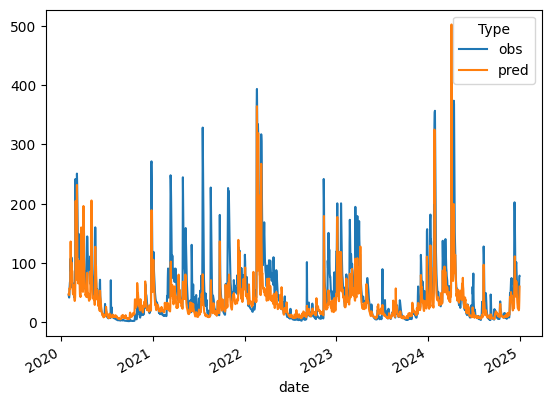

In [ ]:
x.plot.scatter('obs','pred')

In [ ]:
list(model.__dict__.keys())

In [ ]:
model.gcn_kernel